### Import libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import os
import pandas as pd
import data
import rnn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
import seaborn as sns

### Set device for analysis 

In [2]:
# CPU or GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load test data

In [3]:
# File name of test data
test_fname = os.path.join('data', 'artificial_testset.csv')

# Load test data as dataframe
df_data = pd.read_csv(test_fname)

# Create DL dataset (order of inputs/outputs should be the same as in training!)
ds = data.LabeledDataset(inputs=['reward', 'action'],
                         outputs=['action', 'alpha', 'beta'],
                         path=test_fname,
                         backwards_compatible=True)

# Instantiate Data Loader for test data
test_loader = DataLoader(ds, shuffle=False, batch_size=1)

### Load trained model

In [4]:
# Instantiate RNN model
model = rnn.GRU(ds, hidden_size=32, dropout=0, backwards_compatible=True)

# Load checkpoint for model inference
cp = torch.load(os.path.join('checkpoint', 'checkpoint_trnn_5.pth'), map_location='cpu')
print(f"Number of epochs in training: {cp['epoch']}")

# Assign model state
model.load_state_dict(cp['model_state'])

# Change to evaluation mode
model.eval();

Number of epochs in training: 28


### Evaluate model on test data

In [5]:
# Initialize loss objects based on settings from original implementation
loss_obj = {'action': rnn.Loss('BCE', weight=1, tol=1e-10),
            'alpha': rnn.Loss('MSE', weight=1),
            'beta': rnn.Loss('MSE', weight=0.01)}

# Initialize losses as numpy arrays
loss = np.zeros((ds.nagents, len(ds.outputs)))

# Initialize model predictions as numpy arrays
y_alpha = np.zeros((ds.nagents, ds.ntrials))
y_beta = np.zeros((ds.nagents, ds.ntrials))

# Evaluate model on test data
for i, (X, y_true) in enumerate(test_loader):
    # Forward pass
    model(X)
    
    # Save predictions for plotting
    y_alpha[i, :] = model.y['alpha'].flatten().tolist()
    y_beta[i, :] = model.y['beta'].flatten().tolist()
    
    # Compute losses
    loss[i, :] = [loss_obj[val](model.y[val], y_true[j]).item() for j, val in enumerate(loss_obj.keys())]

# Print losses
for i, val in enumerate(loss_obj.keys()):
    print(f"tRNN {loss_obj[val].name} {val} loss: {loss[:, i].mean():.5f} +/- {loss[:, i].std():.5f}")

tRNN BCE action loss: 0.32056 +/- 0.12852
tRNN MSE alpha loss: 0.02428 +/- 0.01207
tRNN MSE beta loss: 0.01915 +/- 0.00949


### Plot loss

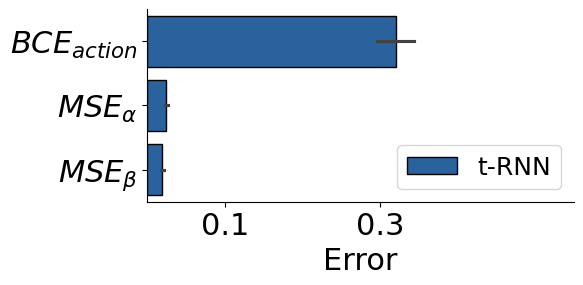

In [6]:
# Collect results in a dataframe
df_loss = pd.DataFrame({'Measurements': loss.flatten(order='F'), 'Model': np.repeat(['t-RNN'], ds.nagents*3),
                        'Type': np.tile(np.repeat([r'$BCE_{action}$', r'$MSE_{\alpha}$', r'$MSE_{\beta}$'], ds.nagents), 1)})

# Initialize figure
plt.figure(figsize=(5.5, 2.5))

# Bar plot
sns.barplot(data=df_loss,
            y='Type', x='Measurements', hue='Model',
            palette=['#1761B0'],
            edgecolor='k',
            errorbar='se',
            orient='h')

# Set axes properties
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Error', size=22)
plt.ylabel('', size=0)
plt.xlim(0, 0.55)
plt.xticks([0.1, 0.3])

# Update legend
plt.legend(fontsize=18)

# Despine and show plot
sns.despine()
plt.show()

### Plot parameter recovery

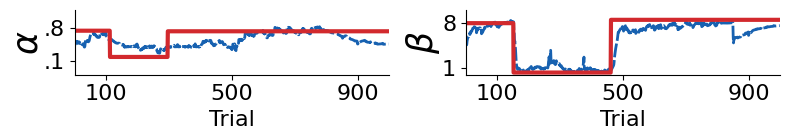

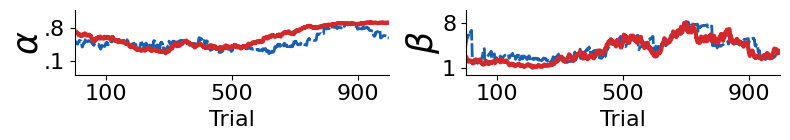

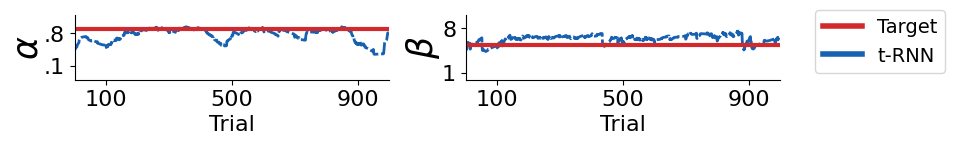

In [7]:
# Colours for line plots
col = ['#D2292D', '#1761B0']

for i in [15, 22, 8]:
    # Select agent data
    df_agent = df_data[df_data['agent']==i]

    # Initialize axes
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 1.5))
    
    # Line plots for alpha
    sns.lineplot(ax=ax0, x=np.arange(ds.ntrials), y=y_alpha[i, :],
                 color=col[1], lw=2, ls=(0, (5, 1))) # prediction
    sns.lineplot(ax=ax0, x=np.arange(ds.ntrials), y=df_agent.alpha,
                 color=col[0], lw=3) # target
    
    # Line plots for beta
    sns.lineplot(ax=ax1, x=np.arange(ds.ntrials), y=y_beta[i, :],
                 color=col[1], lw=2, ls=(0, (5, 1))) # prediction
    sns.lineplot(ax=ax1, x=np.arange(ds.ntrials), y=df_agent.beta,
                 color=col[0], lw=3) # target
    
    # Set axes properties for alpha
    ax0.set_xticklabels([])
    ax0.set_xlim(0, ds.ntrials)
    ax0.set_ylim(-0.2, 1.2)
    ax0.set_ylabel(r'$\alpha$', size=25, labelpad=0)
    ax0.set_yticks([.1, .8])
    ax0.set_yticklabels([.1, 0.8], size=16)
    ax0.set_yticklabels([str(x)[1:] for x in np.round(ax0.get_yticks(), 3)])
    ax0.set_xlim(0, 1000)
    ax0.set_xticks([100, 500, 900])
    ax0.set_xticklabels([100, 500, 900], size=16)
    ax0.set_xlabel('Trial', size=16)

    # Set axes properties for beta
    ax1.set_xlim(0, ds.ntrials)
    ax1.set_ylim(-0.1, 10.1)
    ax1.set_ylabel(r'$\beta$', size=25, labelpad=0)
    ax1.set_yticks([1, 8])
    ax1.set_yticklabels([1, 8], size=16)
    ax1.set_xlabel('Trial', size=16)
    ax1.set_xlim(0, 1000)
    ax1.set_xticks([100, 500, 900])
    ax1.set_xticklabels([100, 500, 900], size=16)
    
    # Add legend
    legend_elements = [Line2D([0], [0], lw=4, color=col[0], label='Target'),
                       Line2D([0], [0], lw=4, color=col[1], label='t-RNN')]
    if i == 8:
        fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1), ncol=1, fontsize=14)

    # Despine and show plot
    sns.despine()
    plt.tight_layout()
    plt.show()